# Chapter 04. Experiment Management
---

## 4.1 Experiments, Trials, and Components
---

In [1]:
# Change into the notebooks directory.
%cd /root/sagemaker-course/notebooks/

/root/sagemaker-course/notebooks


In [2]:
import datetime
import time

import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role

# S3 bucket information
BUCKET = 'sagemaker-course-20200812'
PREFIX = 'mnist'
LOCAL_DATA_DIRECTORY = f'../data/{PREFIX}'
print(f"Artifacts will be written to s3://{BUCKET}/{PREFIX}")

# Session variables we'll use throughout the notebook
sagemaker_session = sagemaker.Session()
boto_session = sagemaker_session.boto_session
sagemaker_client = boto_session.client('sagemaker')
role = get_execution_role()

Artifacts will be written to s3://sagemaker-course-20200812/mnist


In [4]:
from smexperiments.experiment import Experiment

Experiment?

Init signature: Experiment(sagemaker_boto_client, **kwargs)
Docstring:     
An Amazon SageMaker experiment, which is a collection of related trials.

New experiments are created by calling :meth:`~smexperiments.experiment.Experiment.create`. Existing
experiments can be reloaded by calling :meth:`~smexperiments.experiment.Experiment.load`. You can
add a new trial to an Experiment by calling :meth:`~smexperiments.experiment.Experiment.create_trial`.
To remove an experiment and associated trials, trial components by calling :meth:`~smexperiments.experiment
.Experiment.delete_all`.

Examples:
    .. code-block:: python

        from smexperiments import experiment

        my_experiment = experiment.Experiment.create(experiment_name='AutoML')
        my_trial = my_experiment.create_trial(trial_name='random-forest')

        for exp in experiment.Experiment.list():
            print(exp)
        for trial in my_experiment.list_trials():
            print(trial)

        my_experiment.delete

In [5]:
from smexperiments.trial import Trial

Trial?

Init signature: Trial(sagemaker_boto_client, **kwargs)
Docstring:     
An execution of a data-science workflow with an experiment.

Consists of a list of trial component objects, which document individual activities within the workflow.

Examples:
    .. code-block:: python

        from smexperiments import trial, experiment, tracker

        my_experiment = experiment.Experiment.create(experiment_name='AutoML')
        my_trial = trial.Trial.create('AutoML')

        my_tracker = tracker.Tracker.create()
        # log hyper parameter of learning rate
        my_tracker.log_parameter('learning_rate', 0.01)
        my_trial.add_trial_component(my_tracker)

        for trial_component in my_trial.list_trial_components():
            print(trial_component)

        my_trial.remove_trial_component(my_tracker)
        my_trial.delete()

Attributes:
    trial_name (str): The name of the trial.
    experiment_name (str): The name of the trial's experiment.
    tags (List[dict[str, str]]): A 

In [6]:
from smexperiments.trial_component import TrialComponent

TrialComponent?

Init signature: TrialComponent(sagemaker_boto_client, **kwargs)
Docstring:     
This class represents a SageMaker trial component object.

A trial component is a stage in a trial.

Trial components are created automatically within the SageMaker runtime and may not be created directly.
To automatically associate trial components with a trial and experiment supply an experiment config when creating a
job. For example: https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html

Attributes:
    trial_component_name (str): The name of the trial component. Generated by SageMaker from the name of the
        source job with a suffix specific to the type of source job.
    trial_component_arn (str): The ARN of the trial component.
    display_name (str): The name of the trial component that will appear in UI, such as SageMaker Studio.
    source (obj): A TrialComponentSource object with a source_arn attribute.
    status (str): Status of the source job.
    start_time (datetime

### 4.1.2 Use Case: Training a Tensorflow Model on MNIST
---

In [7]:
training_data_bucket = f'sagemaker-sample-data-{boto_session.region_name}'
training_data_prefix = 'tensorflow/mnist'

training_data_uri = f's3://{training_data_bucket}/{training_data_prefix}'
training_data_uri

's3://sagemaker-sample-data-us-east-2/tensorflow/mnist'

In [8]:
boto_session.client('s3').list_objects(
    Bucket=training_data_bucket,
    Prefix=training_data_prefix)

{'ResponseMetadata': {'RequestId': 'F45AB1DA9407A5A0',
  'HostId': 'H/Mhu0krlrynEhtPEwCYyWT1BAcC8RymZm9KH16sgs12KStZUIMdeXWLU1QmNGqKzluNn06SIhM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'H/Mhu0krlrynEhtPEwCYyWT1BAcC8RymZm9KH16sgs12KStZUIMdeXWLU1QmNGqKzluNn06SIhM=',
   'x-amz-request-id': 'F45AB1DA9407A5A0',
   'date': 'Sun, 25 Oct 2020 22:57:48 GMT',
   'x-amz-bucket-region': 'us-east-2',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'IsTruncated': False,
 'Marker': '',
 'Contents': [{'Key': 'tensorflow/mnist/',
   'LastModified': datetime.datetime(2018, 11, 13, 18, 49, 37, tzinfo=tzlocal()),
   'ETag': '"d41d8cd98f00b204e9800998ecf8427e"',
   'Size': 0,
   'StorageClass': 'STANDARD'},
  {'Key': 'tensorflow/mnist/eval_data.npy',
   'LastModified': datetime.datetime(2019, 1, 24, 23, 37, 44, tzinfo=tzlocal()),
   'ETag': '"999d245abdf1f6f45d8b516ef04367e0-4"',
   'Size': 31360128,
   'StorageCl

This tutorial's training script was adapted from TensorFlow's official [CNN MNIST example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/layers/cnn_mnist.py).

In [9]:
!pygmentize '../scripts/tf/tensorflow_mnist.py'

# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.import tensorflow as tf

import tensorflow as tf
import argparse
import os
import numpy as np
import json


def model(x_train, y_train, x_test, y_test):
    """Generate a simple model"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    mod

In [9]:
# Create the Experiment
experiment_name = f"tf-mnist-{datetime.datetime.now().strftime('%Y%m%d%H%M')}"
description = "Classification of mnist hand-written digits using tensorflow 2"

tf_experiment = Experiment.create(experiment_name=experiment_name, 
                                  description=description, 
                                  sagemaker_boto_client=sagemaker_client)

In [10]:
# Create the Trial
trial_name = f"tf-trial-{datetime.datetime.now().strftime('%Y%m%d%H%M')}"

tf_trial = Trial.create(trial_name=trial_name, 
                        experiment_name=tf_experiment.experiment_name,
                        sagemaker_boto_client=sagemaker_client)

### Note: 

The following training job uses an **ml.p2.xlarge** instance. The **ml.p2.xlarge** has a GPU (specifically, it has a single Tesla K80 GPU which you can see on the [Amazon SageMaker ML Instance Types](https://aws.amazon.com/sagemaker/pricing/instance-types/) page). The default AWS quota value for these instances is 0. To increase this, you need to ask for a quota increase. Here are the directions:

1. Open the [Service Quotas console](https://console.aws.amazon.com/servicequotas/).
2. In the navigation pane, choose **AWS services**.
3. Search for and select **Amazon Elastic Compute Cloud (Amazon EC2)** in the list of services.
4. Search for service quota **Running Dedicated p2 Hosts**.
5. Choose its radio button and then click **Request quota increase**.
6. For Change quota value, enter 1 for the value and then click **Request**.
7. To view any pending or recently resolved requests, choose **Dashboard** from the navigation pane. For pending requests, choose the status of the request to open the request receipt. The initial status of a request is **Pending**. After the status changes to **Quota requested**, you'll see the case number with AWS Support. Choose the case number to open the ticket for your request.
8. It can take up to 48 hours for this change to take effect, but it's usually much faster than this. For example, it took about 15 minutes for my request to get handled.

In [13]:
from sagemaker.tensorflow import TensorFlow

# Note: The parameter `enable_cloudwatch_metrics` has been deprecated.
# CloudWatch metrics are already emitted for all Training Jobs, etc.
# See the deprecations in version 2.x of the SDK:
# https://sagemaker.readthedocs.io/en/stable/v2.html#enable-cloudwatch-metrics-for-estimators-and-models

tf_estimator = TensorFlow(
    entry_point='../scripts/tf/tensorflow_mnist.py',
    role=role,
    instance_count=1,
    instance_type='ml.p2.xlarge',
    code_location=f's3://{BUCKET}/{PREFIX}',
    output_path=f's3://{BUCKET}/{PREFIX}',
    base_job_name='tf-mnist',
    py_version='py3',
    framework_version='2.1.0')

**Note: The next cell takes 3-5 minutes to return.**

In [14]:
experiment_config = {
        "TrialName": tf_trial.trial_name,
        "TrialComponentDisplayName": "Training",
    }

# Now associate the estimator with the Experiment and Trial
tf_estimator.fit(inputs={'training': training_data_uri},
                 experiment_config=experiment_config)

INFO:sagemaker:Creating training-job with name: tf-mnist-2020-08-14-11-34-34-425


2020-08-14 11:34:34 Starting - Starting the training job...
2020-08-14 11:34:36 Starting - Launching requested ML instances......
2020-08-14 11:35:43 Starting - Preparing the instances for training......
2020-08-14 11:36:53 Downloading - Downloading input data...
2020-08-14 11:37:12 Training - Downloading the training image........2020-08-14 11:38:43,674 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-08-14 11:38:44,100 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "model_dir": "s3://sagemaker-course-20200812/mnist/tf-mnist-2020-08-14-11-34-34-425/model"
    },
    "input_config_dir": "/opt/ml/input/config",
    "input_da

### 4.1.3 SageMaker Studio Walk-thru
---

At this point you can view the `Experiment` metadata by clicking on the beaker icon in the vertical navigation bar on the left-side of your screen.

## 4.2 Tracking Distributed Hyperparameter Search with Multiple Trials
---

In [18]:
from matplotlib import pyplot as plt
import pandas as pd
from torchvision import datasets, transforms

%config InlineBackend.figure_format = 'retina'

In [23]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Download, load, and transform the data.
train_set = datasets.MNIST(LOCAL_DATA_DIRECTORY, train=True, transform=transform, download=True)
test_set = datasets.MNIST(LOCAL_DATA_DIRECTORY, train=False, transform=transform, download=True)

Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw




Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw
Processing...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


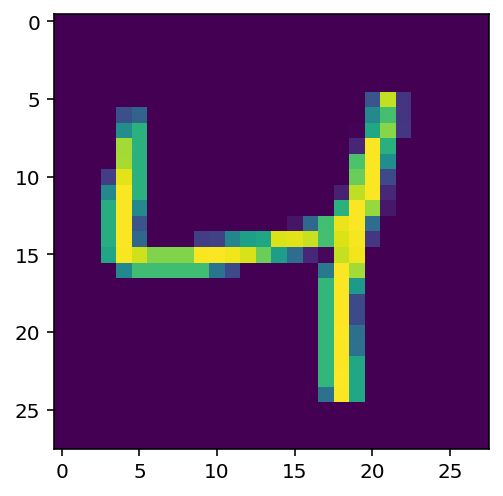

In [24]:
plt.imshow(train_set.data[2].numpy());

In [25]:
inputs = sagemaker_session.upload_data(
    path=LOCAL_DATA_DIRECTORY,
    bucket=BUCKET,
    key_prefix=PREFIX)

In [30]:
from smexperiments.tracker import Tracker

with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sagemaker_client) as tracker:
    tracker.log_parameters({
        "normalization_mean": 0.1307,
        "normalization_std": 0.3081,
    })
    
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

In [31]:
experiment_name = f"torch-mnist-{datetime.datetime.now().strftime('%Y%m%d%H%M')}"
description = "Classification of mnist hand-written digits with pytorch."

mnist_experiment = Experiment.create(experiment_name=experiment_name,
                                     description=description, 
                                     sagemaker_boto_client=sagemaker_client)

**Note: This takes ~15 minutes to return.**

In [32]:
from sagemaker.pytorch import PyTorch

hidden_channel_trial_name_map = {} # Keep references to each Trial object

# If you want to run the following training jobs asynchronously, you may need to increase
# your resource limit. Otherwise, you can run them sequentially.
for i, num_hidden_channel in enumerate([2, 5, 10]):
    
    # create Trial object
    trial_name = f"torch-{num_hidden_channel}-hidden-channels-{datetime.datetime.now().strftime('%Y%m%d%H%M')}"
    cnn_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sagemaker_client,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name
    
    # Associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(tracker.trial_component)
    
    # all input configurations, parameters, and metrics specified in estimator 
    # definition are automatically tracked
    estimator = PyTorch(
        py_version='py3',
        entry_point='../scripts/torch/pytorch_mnist.py',
        role=role,
        sagemaker_session=sagemaker_session,
        framework_version='1.6.0',
        instance_count=1,
        # If you'd prefer to use a CPU for cost, uncomment the following line instead.
        #instance_type='ml.c4.xlarge',
        instance_type='ml.p2.xlarge',
        code_location=f's3://{BUCKET}/{PREFIX}',
        output_path=f's3://{BUCKET}/{PREFIX}',
        base_job_name='torch-mnist',
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': num_hidden_channel,
            'dropout': 0.2,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
            {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
            {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
        ]
    )
    
    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={'training': inputs}, 
        experiment_config={
            'TrialName': cnn_trial.trial_name,
            'TrialComponentDisplayName': 'Training',
        },
        wait=True,
    )
    
    # give it a while before dispatching the next training job
    time.sleep(2)

INFO:sagemaker:Creating training-job with name: torch-mnist-2020-08-14-11-52-01-587


2020-08-14 11:52:01 Starting - Starting the training job...
2020-08-14 11:52:03 Starting - Launching requested ML instances......
2020-08-14 11:53:09 Starting - Preparing the instances for training......
2020-08-14 11:54:30 Downloading - Downloading input data
2020-08-14 11:54:30 Training - Downloading the training image...
2020-08-14 11:54:45 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-14 11:54:47,535 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-14 11:54:47,538 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-14 11:54:47,549 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-14 11:54:47,550 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-14 11:54:47,821 sagemaker-containers INFO  

INFO:sagemaker:Creating training-job with name: torch-mnist-2020-08-14-11-56-16-618


2020-08-14 11:56:16 Starting - Starting the training job...
2020-08-14 11:56:19 Starting - Launching requested ML instances......
2020-08-14 11:57:21 Starting - Preparing the instances for training...
2020-08-14 11:58:02 Downloading - Downloading input data...
2020-08-14 11:58:40 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-14 11:58:41,437 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-14 11:58:41,440 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-14 11:58:41,451 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-14 11:58:41,452 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-14 11:58:41,697 sagemaker-containers INFO     Module pytorch_mnist does not provide a setup.py. 
Generating 

INFO:sagemaker:Creating training-job with name: torch-mnist-2020-08-14-12-00-01-435


2020-08-14 12:00:02 Starting - Starting the training job...
2020-08-14 12:00:04 Starting - Launching requested ML instances......
2020-08-14 12:01:27 Starting - Preparing the instances for training......
2020-08-14 12:02:20 Downloading - Downloading input data...
2020-08-14 12:02:53 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-14 12:02:54,929 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-14 12:02:54,932 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-14 12:02:54,943 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-14 12:02:56,365 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-14 12:02:56,607 sagemaker-containers INFO     Module pytorch_mnist does not provide a setup.py. 
Generati

### 4.2.3 SageMaker Studio Walk-thru
---

At this point you can view the `Experiment` metadata by clicking on the beaker icon in the vertical navigation bar on the left-side of your screen.

## 4.3 Analyzing Experiment Results
---

In [33]:
from sagemaker.analytics import ExperimentAnalytics

search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=sagemaker_session, 
    experiment_name=mnist_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=['test:accuracy'],
    parameter_names=['hidden_channels', 'epochs', 'dropout', 'optimizer']
)

In [34]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,dropout,epochs,hidden_channels,optimizer,test:accuracy - Min,test:accuracy - Max,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count,training - MediaType,training - Value,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value
0,torch-mnist-2020-08-14-12-00-01-435-aws-traini...,Training,arn:aws:sagemaker:us-east-2:209970524256:train...,0.2,2.0,10.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2,None,s3://sagemaker-course-20200812/mnist,None,s3://sagemaker-course-20200812/mnist,None,s3://sagemaker-course-20200812/mnist/torch-mni...
1,torch-mnist-2020-08-14-11-52-01-587-aws-traini...,Training,arn:aws:sagemaker:us-east-2:209970524256:train...,0.2,2.0,2.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2,None,s3://sagemaker-course-20200812/mnist,None,s3://sagemaker-course-20200812/mnist,None,s3://sagemaker-course-20200812/mnist/torch-mni...
2,torch-mnist-2020-08-14-11-56-16-618-aws-traini...,Training,arn:aws:sagemaker:us-east-2:209970524256:train...,0.2,2.0,5.0,"""sgd""",94.0,96.0,95.0,1.414214,96.0,2,None,s3://sagemaker-course-20200812/mnist,None,s3://sagemaker-course-20200812/mnist,None,s3://sagemaker-course-20200812/mnist/torch-mni...


In [35]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=sagemaker_session, 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": hidden_channel_trial_name_map[2]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [36]:
lineage_table.dataframe()

,TrialComponentName,DisplayName,normalization_mean,normalization_std,mnist-dataset - MediaType,mnist-dataset - Value,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,...,train:loss - Avg,train:loss - StdDev,train:loss - Last,train:loss - Count,training - MediaType,training - Value,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value
0,TrialComponent-2020-08-14-115152-cpql,Preprocessing,0.1307,0.3081,s3/uri,s3://sagemaker-course-20200812/mnist,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,torch-mnist-2020-08-14-11-52-01-587-aws-traini...,Training,NaN,NaN,NaN,NaN,arn:aws:sagemaker:us-east-2:209970524256:train...,520713654638.dkr.ecr.us-east-2.amazonaws.com/s...,1.0,ml.c4.xlarge,...,0.456703,0.352488,0.157259,18.0,NaN,s3://sagemaker-course-20200812/mnist,NaN,s3://sagemaker-course-20200812/mnist,NaN,s3://sagemaker-course-20200812/mnist/torch-mni...
